# Topic Classification

This small project focusses on multiclass text classification. I na first step an extensive data analysis is conducted and afterwards a machine learning model built which can automatically label the topic of a newspaper headline.

The data used here is from the New York Times headlines and topics data set from Amber Ellen Boydstun: http://www.amber-boydstun.com/supplementary-information-for-making-the-news.html. It has to be unzipped in the same folder as this notebook, converted into UTF8 format and named *boydstun_nyt_frontpage_dataset_utf8.csv*.

## Quickjump Links

<a href="#eda">Exploratory Data Analysis</a>

<a href="#textanalysis">Text Analysis</a>

<a href="#mlmodel">Machine Learning Model</a>

<a href="#conclusion">Conclusion</a>

## Packages

The code for this task makes use of the following packages: scikit-learn, NLTK, pandas, typing, matplotlib and seaborn.

In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# load nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# use seaborn to get more beautiful plots
sns.set_theme()

# define fontsize of plots
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# load data set
nyt_data_set = pd.read_csv(
    'boydstun_nyt_frontpage_dataset_utf8.csv',
    index_col='id'
    )

[nltk_data] Downloading package punkt to /home/raffael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raffael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raffael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="eda"></a>
## Exploratory Data Analysis

A quick look at the dataset:

In [123]:
display(nyt_data_set.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31034 entries, 1 to 31034
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        31034 non-null  int64 
 1   majortopic  31034 non-null  int64 
 2   subtopic    31034 non-null  int64 
 3   title       31031 non-null  object
 4   summary     30976 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


None

In [124]:
display(nyt_data_set.head())

,year,majortopic,subtopic,title,summary
id,,,,,
1,1996,12,1205,Nation's Smaller Jails Struggle To Cope With S...,Jails overwhelmed with hardened criminals
2,1996,23,2300,Dancing (and Kissing) In the New Year,new years activities
3,1996,20,2012,Forbes's Silver Bullet for the Nation's Malaise,Steve Forbes running for President
4,1996,16,1602,"Up at Last, Bridge to Bosnia Is Swaying Gatewa...",U.S. military constructs bridge to help their ...
5,1996,20,2012,2 SIDES IN SENATE DISAGREE ON PLAN TO END FURL...,Democrats and Republicans can't agree on plan ...


Every row consists of a NYT headline ('title'), a very brief summary of the headline article ('summary'), the 'year' in which the newspaper was printed and a nummeric code to categorize the topic of the article ('majortopic' and 'subtopic'). The columns 'title' and 'summary' can be used to predict the column 'majortopic'. There are a few missing values in these columns. As it is far less than 1% of the records which are incomplete we simply drop them.

In [125]:
# drop rows with missing values in relevant columns
nyt_data_set.dropna(subset=['title', 'summary', 'majortopic'], inplace=True)

Both, the headline and the summary seem to be very brief. To get an overview how long these texts really are we create histogram.

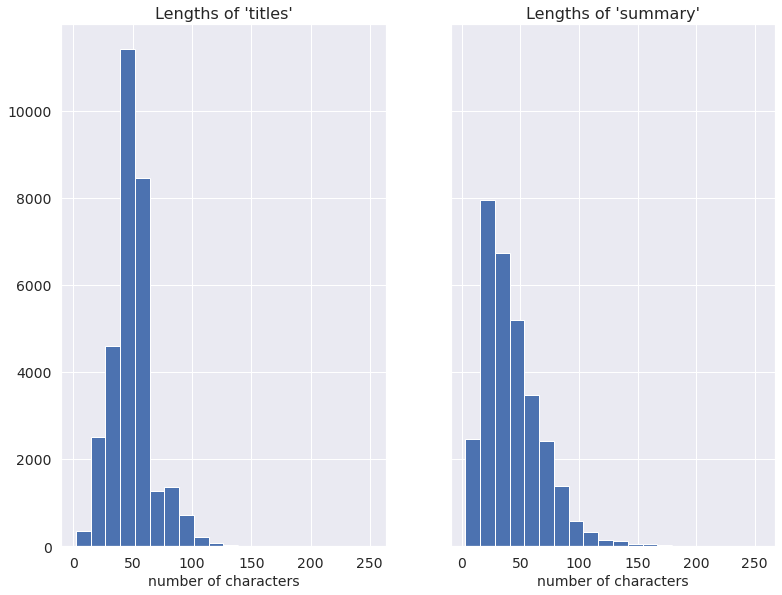

In [126]:
# create histograms of the string lengths
fig, axs = plt.subplots(1, 2, sharey=True, figsize=[2*6.4, 2*4.8])
nyt_data_set['title'].apply(len).hist(ax=axs[0], bins=20)
nyt_data_set['summary'].apply(len).hist(axes=axs[1], bins=20)
axs[0].set(xlabel='number of characters', title='Lengths of \'titles\'')
axs[1].set(xlabel='number of characters', title='Lengths of \'summary\'')
plt.show()

The titles and summarys are rather short (almost all of them have less than 100 characters), but their lengths do not vary very stongly. Next we check the labels. Every storys major topic is categorized with a numeric code. The topic corresponding to each code can be found in the codebook: http://www.amber-boydstun.com/uploads/1/0/6/5/106535199/nyt_front_page_policy_agendas_codebook.pdf

For some further data-exploration, we join the codebook with the data set and get new dataframe.

In [127]:
# read codebook from csv file
codebook = pd.read_csv('codebook.csv', sep=';', header=None, names=['majortopic', 'mtopic_text'])

# join with headline data set
nyt_data_set_text = nyt_data_set.merge(codebook, how='left', on='majortopic')

display(nyt_data_set_text.head())

,year,majortopic,subtopic,title,summary,mtopic_text
0,1996,12,1205,Nation's Smaller Jails Struggle To Cope With S...,Jails overwhelmed with hardened criminals,"Law, Crime, and Family Issues"
1,1996,23,2300,Dancing (and Kissing) In the New Year,new years activities,NaN
2,1996,20,2012,Forbes's Silver Bullet for the Nation's Malaise,Steve Forbes running for President,Government Operations
3,1996,16,1602,"Up at Last, Bridge to Bosnia Is Swaying Gatewa...",U.S. military constructs bridge to help their ...,Defense
4,1996,20,2012,2 SIDES IN SENATE DISAGREE ON PLAN TO END FURL...,Democrats and Republicans can't agree on plan ...,Government Operations


Apparently not all topic-codes are in the codebook, lets check which ones are missing.

In [128]:
display(nyt_data_set_text[nyt_data_set_text['mtopic_text'].isna()].value_counts('majortopic'))

majortopic
23    761
9     320
dtype: int64

23 and 9 seem to be missing, so we just use the number instead of the text.

In [129]:
# replace NaN in 'mtopic_txt' with the 'majortopic' code
nyt_data_set_text.loc[nyt_data_set_text['mtopic_text'].isna(), 'mtopic_text'] \
= nyt_data_set_text[nyt_data_set_text['mtopic_text'].isna()]['majortopic']

Some topics might appear more often in the headlines than others. For a machine learning model it is important to know, whether a dataset is balanced or not.

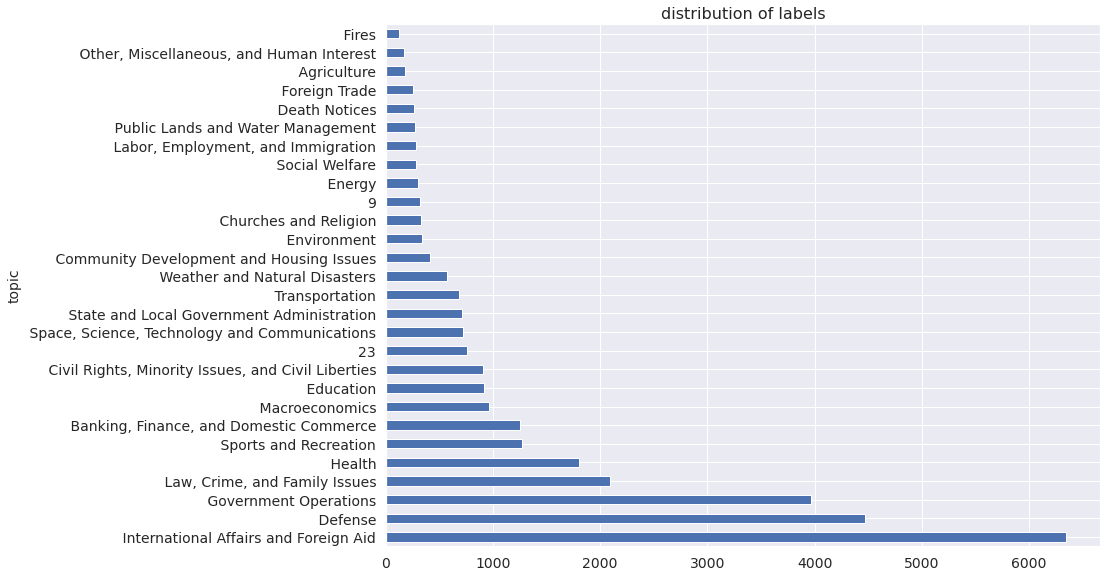

In [130]:
# create a histogram of the label distribution
fig, ax = plt.subplots(figsize=[2*6.4, 2*4.8])
nyt_data_set_text['mtopic_text'].value_counts().plot.barh(ax=ax)
ax.set(ylabel='topic', title='distribution of labels')
plt.show()

In [131]:
# count the distinct label categories
len(nyt_data_set_text['majortopic'].unique())

28

There are 28 different topics as labels. The set is very inbalanced. Most of the headlines are either 'International Affairs', 'Defense', or 'Government Opperations' (20), which makes sense for a newspaper like the NYT. Topics with very few headlines are e.g. 'Fires', 'Sports and Recreation', 'Agriculture', 'Foreign Trade' and 'Death Notices'.

It might be interesting to see, how this evolved over the years. Have certain topics become more prevalent?

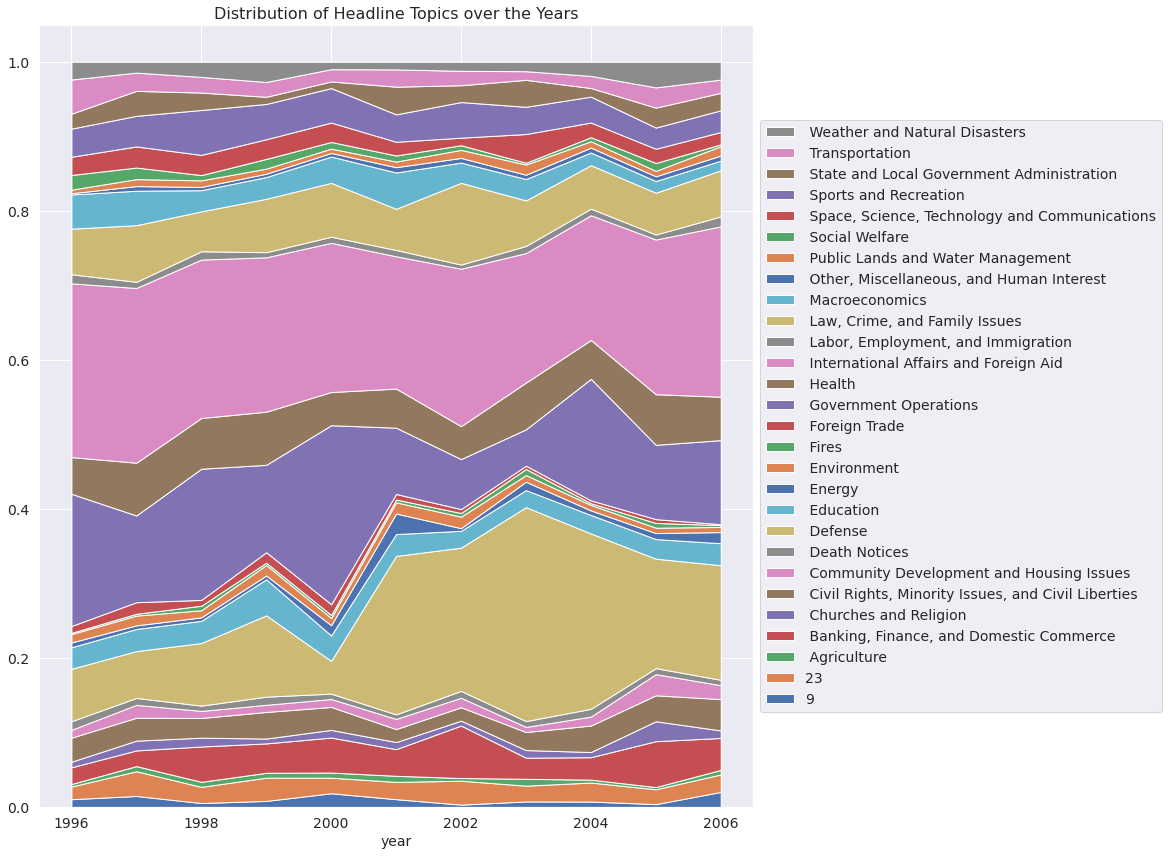

In [132]:
# count the headlines for each topic per year
topic_year = nyt_data_set_text.groupby(['mtopic_text', 'year'])['majortopic'].count().unstack()

# normalize per year
topic_year_norm = topic_year / topic_year.sum()

# plot evolution
fig, ax = plt.subplots(figsize=[2*6.4, 3*4.8])
ax.stackplot(np.array(topic_year_norm.columns), 
             topic_year_norm.to_numpy(), 
             labels=list(topic_year_norm.index))

ax.set(xlabel='year', title='Distribution of Headline Topics over the Years')

# make sure the order of the label matches the actual order of the colors in the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

It is clearly visible, how around the year 2001 the 'Defense' strongly increased while 'Government Operations' shifted out of focus. This was probably the results of the 9/11 terror attack in New York and the subsequent wars in the middle east.

<a id="textanalysis"></a>
## Text-Analysis

So far we mostly looked at the information contained by the labels of the headlines. But the final goal of this project is to access the information stored in natural language. In a first step we combine the 'title' and the 'summary' column into one string and prepare it for further work.

The following preprocessing steps are performed:
* tokenization
* removal of non-alphabetical tokens
* removal of common stopwords
* lemmatization

In [133]:
def preprocess_headline(string: str) ->  List[str]:
    """Preprocess one headline by performing tokenization, removal of
    non-alphabetical tokens and stopwords, lemmatization.
    
    Args:
        string: One headline as a single string
    
    Returns:
        A list of preprocessed tokens.
    
    """
    # tokenize input
    tokens = word_tokenize(string)

    # remove non-alphabetical tokens
    tokens_alpha = [w.lower() for w in tokens if w.isalpha()]

    # remove stopwords
    tokens_no_stops = [w for w in tokens_alpha
                       if w not in stopwords.words('english')]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(w) for w in tokens_no_stops]

    return tokens_lemma


# combine the titel and the summary for each row into one string
nyt_data_set['titlesummary'] = nyt_data_set['title'] + ' ' + nyt_data_set['summary']

# preprocess all the combined titel-summary strings
nyt_data_set['pre'] = nyt_data_set['titlesummary'].apply(preprocess_headline)

With the headlines being processed into meaningful tokens it would be intersting to know, which words appeared most often in the headlines and how this changed over the years. So lets create a ranking of the most frequent words for every year.

In [134]:
# count number of entries per year
val_ct = nyt_data_set['year'].value_counts()

# crea an ordered list with all the years
years = list(val_ct.index)
years.sort()

# DF to store the most frequent words per year
most_freq = pd.DataFrame(columns=years)

# dict with all the counts per year
all_cts = {}

# count word occurence for every year
for year in years:
    string = nyt_data_set[nyt_data_set['year']==year]['pre'].explode().tolist()
    fdist = nltk.FreqDist(string)
    most_freq[year] = [el[0] for el in fdist.most_common(30)]
    all_cts[year] = dict(fdist)

# show the most frequnet words for every year
display(most_freq)

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,new,new,clinton,new,campaign,bush,bush,iraq,iraq,new,new
1,clinton,clinton,new,clinton,bush,nation,new,war,election,iraq,iraq
2,dole,york,president,balkan,new,challenged,iraq,u,bush,bush,bush
3,politics,city,overview,crisis,gore,new,scandal,bush,new,iraqi,york
4,election,campaign,iraq,kosovo,clinton,plan,enron,iraqi,presidential,court,iraqi
5,campaign,report,testing,trial,vote,attack,u,new,iraqi,case,plan
6,crash,house,impeachment,york,court,u,plan,threat,kerry,plan,city
7,plan,leader,campaign,overview,election,president,say,response,attack,election,war
8,welfare,china,york,nato,plan,taliban,attack,plan,nyc,nyc,election
9,republican,president,plan,school,senate,china,war,nation,campaign,york,photo


We can also track the appearance of certain words in the headlines over the years. Certain topics might constantly be in the headlines, while others appear just duraing or after certain events.

In [135]:
def track_word(word: str, 
               freq_dict: Dict[int, Dict[str, int]], 
               cts_total: pd.DataFrame
              ) -> Tuple[List[int], List[float]]:
    """ Calculates the occurance frequency of a word in the headlines for all recorded years.
    
    Args:
        word: Word to calculate the frequency for.
        freq_dict: Dictionary with years and dictionaries with word counts for each year.
        cts_total: Number of entries per year.
    
    Returns:
        A tuple with a list with all the recorded years and a list with the word frequencies.
    
    """
    # create an ordered list with all the years
    years = list(cts_total.index)
    years.sort()
    
    # return realtive count of a word - 0 if word isn't found
    norm_cts = [freq_dict[year].get(word, 0) / cts_total[year] for year in years]
    
    return years, norm_cts


def plot_word_track(word_list: List[str], 
                    freq_dict: Dict[int, Dict[str, int]], 
                    cts_total: pd.DataFrame
                   ) -> None:
    """ Plots the occurance frequency of a list of words in the headlines for all recorded years.
    
    Args:
        word_list: List of words to plot the frequency for.
        freq_dict: Dictionary with years and dictionaries with word counts for each year.
        cts_total: Number of entries per year.
    
    """
    # plot all relative word counts into one figure
    fig, ax = plt.subplots(figsize=[2*6.4, 2*4.8])

    for wrd in word_list:
        x_list, y_list = track_word(wrd, freq_dict, cts_total)
        ax.plot(x_list, y_list, label=wrd)

    ax.set(
        xlabel='year',
        ylabel='word frequency',
        title='The Appearance of Certain Words in the Headlines'
    )
    plt.legend()
    plt.show()

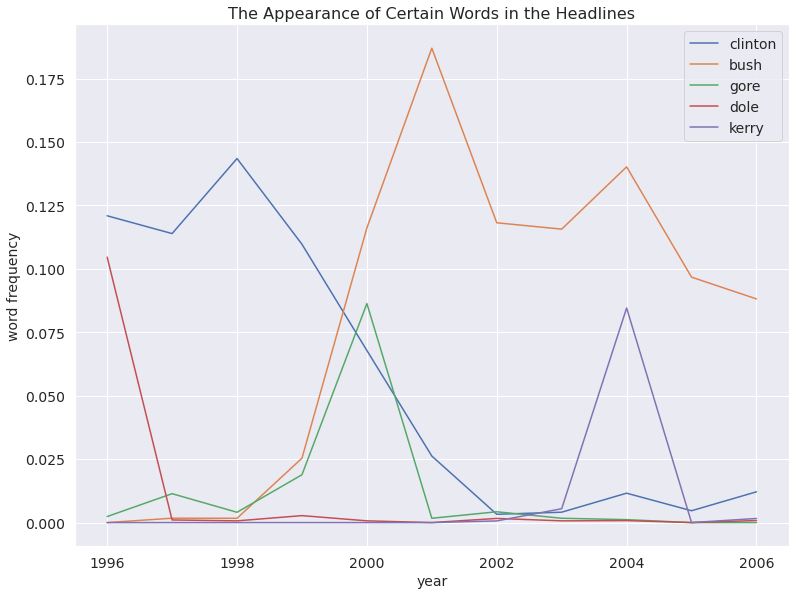

In [136]:
plot_word_track(['clinton', 'bush', 'gore', 'dole', 'kerry'], all_cts, val_ct)

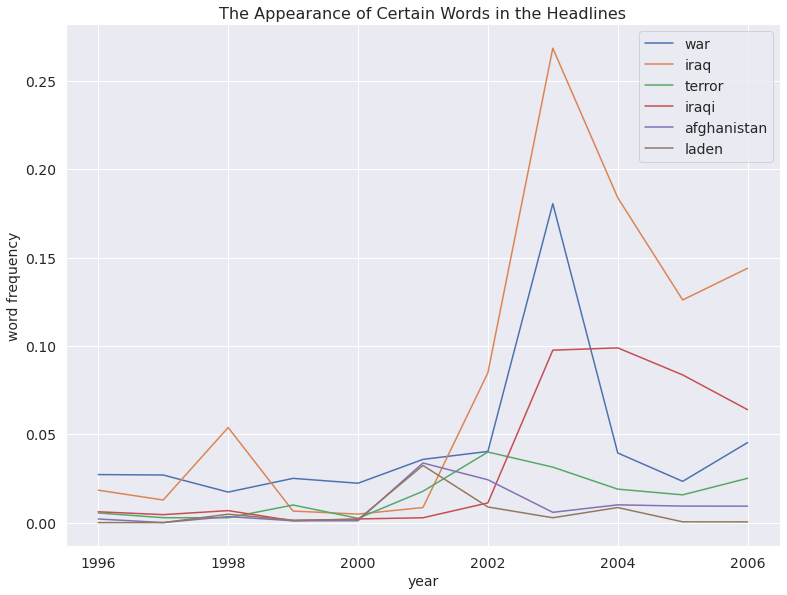

In [137]:
plot_word_track(['war', 'iraq', 'terror', 'iraqi', 'afghanistan','laden'], all_cts, val_ct)

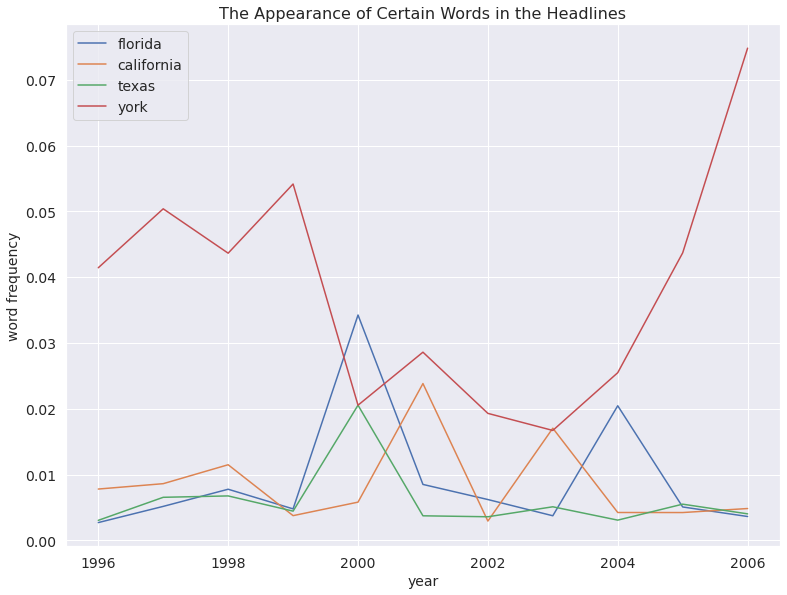

In [138]:
plot_word_track(['florida', 'california', 'texas', 'york'], all_cts, val_ct)

<a id="mlmodel"></a>
## Machine Learning Model

The preprocessed combined titel and summary are used as features and the numeric code for majortopic as the labels. The data set is split into 20% development, 20% test and 60% training data. The training set is used to train the model, the development set to tune some (hyper-)parameters and the test set finally to evaluate the performance of the model.

In [139]:
# size of the test and development set
n_test = int(nyt_data_set.shape[0]*0.2)
n_dev = int(nyt_data_set.shape[0]*0.2)

# split into distinct sets - title and summary are combined to one string
headlines_train, headlines_test, labels_train, labels_test = train_test_split(
    nyt_data_set['pre'].tolist(),
    nyt_data_set['majortopic'].tolist(),
    test_size=n_test,
    random_state=42
    )

headlines_train, headlines_dev, labels_train, labels_dev = train_test_split(
    headlines_train,
    labels_train,
    test_size=n_dev,
    random_state=42
    )

Bag of word vectors are used as features to train an unregularized logistic regression model with different vocabulary sizes. The performance is then evaluated on the test set.

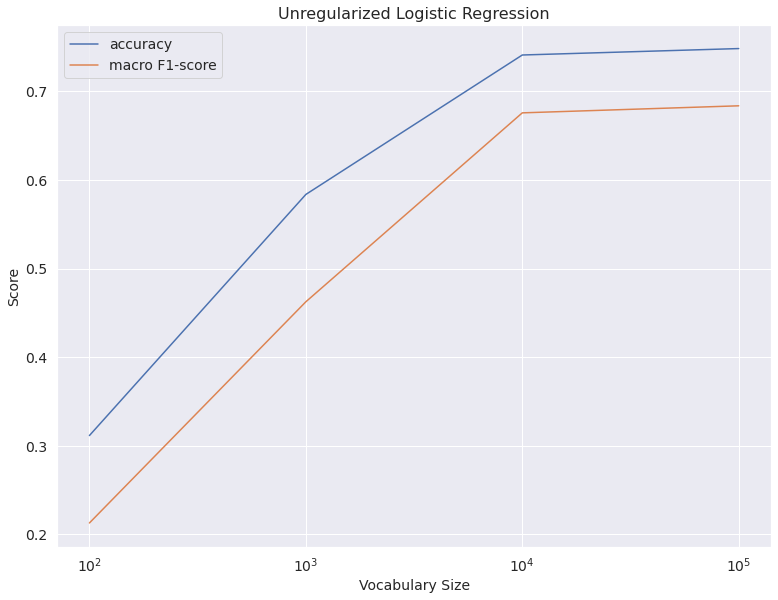

In [140]:
def evaluate_model(voc_size: int, 
                   penalty: str = 'none', 
                   l2_C: float = 1, 
                   solver: str = 'lbfgs'
                  ) -> Tuple[float, float]:
    """ Uses a bag of word vectorizer with specified vocabulary size to train and evaluate a
    logistic regression model on the headlines.
    
    Args:
        voc_size: Size of the vocabulary.
        penalty: Penalty for logistic regression.
        l2_C: C of logistic regression.
        solver: Solver of logistic regression.
    
    Returns:
        Accuracy and F1 score on test set.
    
    """
    # headlines are already tokenized, therefore a dummy function
    # is passed to the vectorizer
    def dummy_tokenizer(text):
        return text

    # BOW vectorization of the training and test reviews
    vectorizer = CountVectorizer(
        lowercase=False,
        tokenizer=dummy_tokenizer,
        token_pattern=None,
        max_features=voc_size
        )

    vectorizer.fit(headlines_train)
    headlines_train_bow = vectorizer.transform(headlines_train)
    headlines_test_bow = vectorizer.transform(headlines_test)

    # train and predict with logistic regression
    clf = LogisticRegression(C=l2_C, penalty=penalty, max_iter=5000, class_weight='balanced', solver=solver)
    clf.fit(headlines_train_bow, labels_train)
    labels_test_pred = clf.predict(headlines_test_bow)

    acc = accuracy_score(labels_test, labels_test_pred)
    f1 = f1_score(labels_test, labels_test_pred, average='macro')

    return acc, f1


# vocabulary size
voc_size_lst = [10**2, 10**3, 10**4, 10**5]

acc_lst = []
f1_lst = []

for voc_size in voc_size_lst:
    acc, f1 = evaluate_model(voc_size, solver='saga')
    acc_lst.append(acc)
    f1_lst.append(f1)


fig, ax = plt.subplots(figsize=[2*6.4, 2*4.8])
ax.plot(voc_size_lst, acc_lst, label='accuracy')
ax.plot(voc_size_lst, f1_lst, label='macro F1-score')
ax.set_xscale('log')
ax.set(
        title='Unregularized Logistic Regression',
        ylabel='Score',
        xlabel='Vocabulary Size'
        )
ax.legend(loc='best')

plt.show()

To improve performance, an L<sub>2</sub> penalty is applied and tuned on the performance set for each vocabulary size.

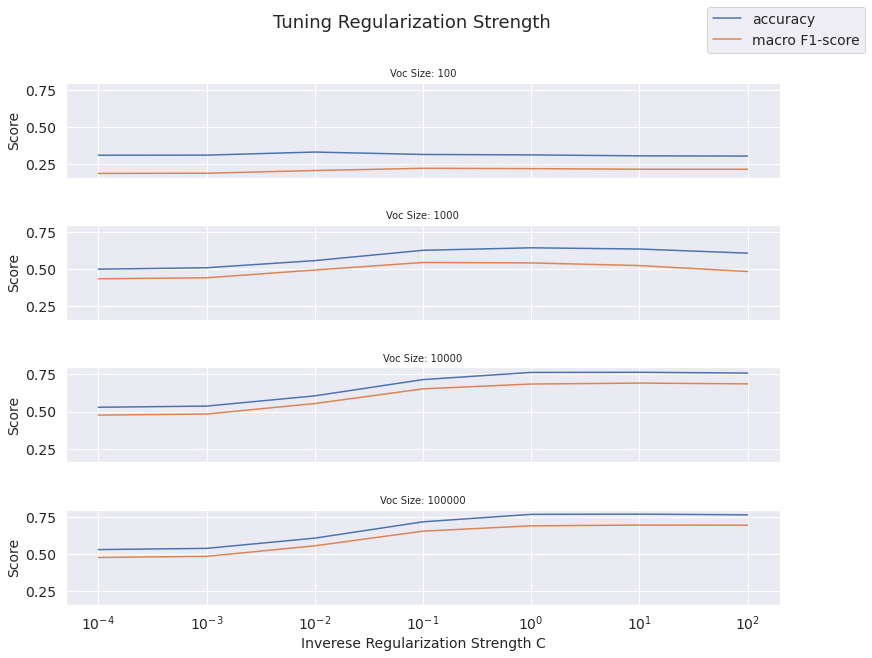

In [141]:
def tune_l2(voc_size: int, C_list: List[int]) -> Tuple[List[float], List[float]]:
    """ Uses a bag of word vectorizer with specified vocabulary size to train and evaluate multiple
    logistic regression model on the headlines. Each model uses a different C with L2 penalty for 
    regularization.
    
    Args:
        voc_size: Size of the vocabulary.
        C_list: List of C to use with logistic regression.
        
    Returns:
        Two list with the accuracies and the f1 scores coresponding to the C of the C_list.
    
    """
    # headlines are already tokenized, therefore a dummy function
    # is passed to the vectorizer
    def dummy_tokenizer(text):
        return text

    # BOW vectorization of the training and test reviews
    vectorizer = CountVectorizer(
        lowercase=False,
        tokenizer=dummy_tokenizer,
        token_pattern=None,
        max_features=voc_size
        )

    vectorizer.fit(headlines_train)
    headlines_train_bow = vectorizer.transform(headlines_train)
    headlines_dev_bow = vectorizer.transform(headlines_dev)

    acc_list = []
    f1_list = []

    for C_ in C_list:

        # train and predict with logistic regression
        clf = LogisticRegression(C=C_, penalty='l2', max_iter=5000, class_weight='balanced')
        clf.fit(headlines_train_bow, labels_train)
        labels_dev_pred = clf.predict(headlines_dev_bow)

        acc_list.append(accuracy_score(labels_dev, labels_dev_pred))
        f1_list.append(f1_score(labels_dev, labels_dev_pred, average='macro'))

    return acc_list, f1_list


# vocabulary size
voc_size_lst = [10**2, 10**3, 10**4, 10**5]

fig, axs = plt.subplots(len(voc_size_lst), 1, 
                        sharex=True, 
                        sharey=True, 
                        figsize=[2*6.4, 2*4.8]
                       )

for i, voc_size in enumerate(voc_size_lst):

    # values for C to try
    C_list = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]

    acc_lst, f1_lst = tune_l2(voc_size, C_list)

    axs[i].plot(C_list, acc_lst)
    axs[i].plot(C_list, f1_lst)
    axs[i].set_xscale('log')
    axs[i].set_title('Voc Size: ' + str(voc_size), size=10)
    axs[i].set_ylabel('Score')

plt.subplots_adjust(hspace=0.5)
axs[-1].set(xlabel='Inverese Regularization Strength C')
fig.suptitle('Tuning Regularization Strength')
fig.legend(['accuracy', 'macro F1-score'])
plt.show()

For each vocabulary size we apply the regularzation strength which performed best on the development set and evaluate the model again on the test set.

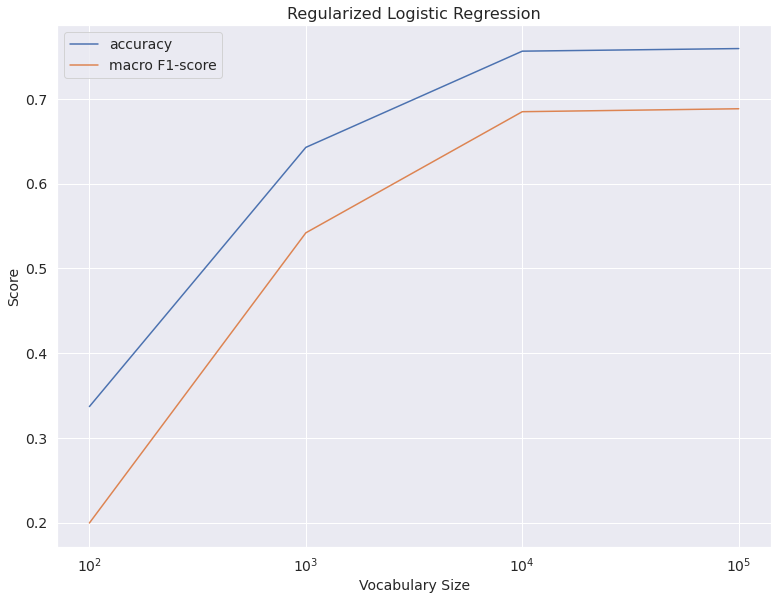

In [142]:
# vocabulary size and the according value for C
voc_size_lst = [10**2, 10**3, 10**4, 10**5]
C_best_lst = [10**-2, 10**0, 10**1, 10**1]

acc_lst = []
f1_lst = []

for voc_size, C_best in zip(voc_size_lst, C_best_lst):
    acc, f1 = evaluate_model(voc_size, penalty='l2', l2_C=C_best)
    acc_lst.append(acc)
    f1_lst.append(f1)


fig, ax = plt.subplots(figsize=[2*6.4, 2*4.8])
ax.plot(voc_size_lst, acc_lst, label='accuracy')
ax.plot(voc_size_lst, f1_lst, label='macro F1-score')
ax.set_xscale('log')
ax.set(
        title='Regularized Logistic Regression',
        ylabel='Score',
        xlabel='Vocabulary Size'
        )
ax.legend(loc='best')

plt.show()

<a id="conclusion"></a>
## Conclusion

The accuracy of the classifier increases with the vocabulary size, both in the regularized and the unregularized case. There are many different target classes and the set is heavily inbalanced. To account for that, balanced class weights are used. This approach basically punishes wrong predictions in rare classes harder than in frequent classes. In a small vocabulary, words which are specific to the rare classes and therefore do not appear often, might be lost. This could make it more difficult to predict them correctly and so decreas the overall accuracy.

In the regularized case, the parameter C is the inverse regularization strength. Smaller values specify stronger regularization. If the vocabulary is small, regularization does not have a big influence. With increasing vocabulary size, the choice of the parameter C becomes more important and can boost the accuracy. The more words there are in the vocabulary, the higher dimensional the feature-space will be. More features generally increase the potential to overfit and therefore benefit from regularization.

This classifier might work quite well on the given dataset. But as it was shown in the data analysis part, many important topics appear only after a certain time. So headlines, which are from a time after 2006, might be classified significantly worse. Topics such as "Obama", "Trump" or "Corona-Virus" are not really present in the training set.